# Multiple Kernel Learning Algorithms

In [29]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from scipy.optimize import minimize, Bounds
import warnings
from cvxopt import matrix, solvers
import time

# Suppress warnings
warnings.filterwarnings('ignore')
solvers.options['show_progress'] = False

# Helper functions

In [30]:
def center_kernel(K):
    """Center a kernel matrix K"""
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    return K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

def kernel_alignment(K1, K2):
    """Compute alignment between two kernels"""
    return np.sum(K1 * K2) / np.sqrt(np.sum(K1 * K1) * np.sum(K2 * K2))

def centered_kernel_alignment(K1, K2):
    """Compute centered alignment between two kernels"""
    K1_centered = center_kernel(K1)
    K2_centered = center_kernel(K2)
    return kernel_alignment(K1_centered, K2_centered)

# Base Model

In [31]:
class BaseMKL(BaseEstimator, ClassifierMixin):
    """Base class for Multiple Kernel Learning algorithms"""

    def __init__(self, C=1.0, kernel_types=None):
        self.C = C
        self.kernel_types = kernel_types if kernel_types else ['linear', 'rbf', 'poly']
        self.kernel_weights = None
        self.svm = None
        self.combined_kernel_matrix_train = None

    def _get_kernel_matrix(self, X, kernel_type, X_train=None):
        """Compute kernel matrix for a specific kernel type"""
        if kernel_type == 'linear':
            return linear_kernel(X) if X_train is None else linear_kernel(X, X_train)
        elif kernel_type == 'rbf':
            gamma = 1.0 / X.shape[1]
            return rbf_kernel(X, gamma=gamma) if X_train is None else rbf_kernel(X, X_train, gamma=gamma)
        elif kernel_type == 'poly':
            return polynomial_kernel(X, degree=2) if X_train is None else polynomial_kernel(X, X_train, degree=2)
        else:
            raise ValueError(f"Unknown kernel type: {kernel_type}")

    def _get_kernel_matrices(self, X, X_train=None):
        """Compute all kernel matrices for all kernel types"""
        kernel_matrices = []
        for kernel_type in self.kernel_types:
            kernel_matrices.append(self._get_kernel_matrix(X, kernel_type, X_train))
        return kernel_matrices

    def _combine_kernels(self, kernel_matrices):
        """Combine kernels using kernel weights"""
        if self.kernel_weights is None:
            # Default to equal weights if not set
            self.kernel_weights = np.ones(len(kernel_matrices)) / len(kernel_matrices)

        combined_kernel = np.zeros_like(kernel_matrices[0])
        for i, kernel in enumerate(kernel_matrices):
            combined_kernel += self.kernel_weights[i] * kernel

        return combined_kernel

    def _precomputed_kernel(self, X, Y=None):
        """Return the precomputed kernel matrix"""
        if Y is not None:
            # For prediction phase
            kernel_matrices = self._get_kernel_matrices(Y, X)
            return self._combine_kernels(kernel_matrices)
        else:
            # For training phase
            return self.combined_kernel_matrix_train

    def fit(self, X, y):
        """Fit the MKL model"""
        # Store training data for future predictions
        self.X_train = X

        # Compute kernel matrices for training data
        kernel_matrices = self._get_kernel_matrices(X)

        # Set kernel weights (to be implemented by subclasses)
        self._set_kernel_weights(kernel_matrices, y)

        # Combine kernels
        self.combined_kernel_matrix_train = self._combine_kernels(kernel_matrices)

        # Train SVM with combined kernel
        self.svm = SVC(C=self.C, kernel='precomputed')
        self.svm.fit(self.combined_kernel_matrix_train, y)

        return self

    def predict(self, X):
        """Predict classes for samples in X"""
        # Compute kernel between test and training data
        K_test = self._precomputed_kernel(self.X_train, X)

        # Use SVM to predict with the combined kernel
        return self.svm.predict(K_test)

    def _set_kernel_weights(self, kernel_matrices, y):
        """Set kernel weights (to be implemented by subclasses)"""
        raise NotImplementedError("Subclasses must implement this method")

# 1. Single-Kernel SVM (Best)


In [32]:
class SVMBest(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        # Evaluate each kernel separately
        best_acc = -1
        best_kernel_idx = 0

        # Create a small validation split indices instead of using dummy features
        n_samples = len(y)
        indices = np.arange(n_samples)
        train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

        for i, kernel in enumerate(kernel_matrices):
            # Use only training indices for this kernel
            K_train = kernel[np.ix_(train_idx, train_idx)]
            K_val = kernel[np.ix_(val_idx, train_idx)]

            # Train and evaluate SVM with this kernel
            svm = SVC(C=self.C, kernel='precomputed')
            svm.fit(K_train, y[train_idx])
            preds = svm.predict(K_val)
            acc = accuracy_score(y[val_idx], preds)

            if acc > best_acc:
                best_acc = acc
                best_kernel_idx = i

        # Set weight to 1 for the best kernel, 0 for others
        self.kernel_weights = np.zeros(len(kernel_matrices))
        self.kernel_weights[best_kernel_idx] = 1.0

# 2. Single-Kernel SVM (All)


In [33]:
class SVMAll(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        # Use equal weights for all kernels
        self.kernel_weights = np.ones(len(kernel_matrices)) / len(kernel_matrices)

# 3. RBMKL (Mean)


In [34]:
class RBMKLMean(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        # Use equal weights for all kernels (unweighted mean)
        self.kernel_weights = np.ones(len(kernel_matrices)) / len(kernel_matrices)

# 4. RBMKL (Product)


In [35]:
class RBMKLProduct(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _combine_kernels(self, kernel_matrices):
        """Combine kernels using product instead of sum"""
        combined_kernel = np.ones_like(kernel_matrices[0])
        for kernel in kernel_matrices:
            # Element-wise product
            combined_kernel *= kernel

        # Normalize to avoid numerical issues
        if np.max(combined_kernel) > 0:
            combined_kernel /= np.max(combined_kernel)

        return combined_kernel

    def _set_kernel_weights(self, kernel_matrices, y):
        # Not used for product kernel, but implemented for consistency
        self.kernel_weights = np.ones(len(kernel_matrices))

# 5. ABMKL (Ratio)


In [36]:
class ABMKLRatio(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)
        self.kernel_weights = np.zeros(n_kernels)

        # Create target kernel from labels (outer product of labels)
        y_matrix = np.outer(y, y)

        # Compute alignment between each kernel and target
        for i in range(n_kernels):
            self.kernel_weights[i] = kernel_alignment(kernel_matrices[i], y_matrix)

        # Normalize weights to sum to 1
        if np.sum(self.kernel_weights) > 0:
            self.kernel_weights /= np.sum(self.kernel_weights)

# 6. ABMKL (Conic)


In [37]:
class ABMKLConic(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Create target kernel from labels
        y_matrix = np.outer(y, y)

        # Set up the QCQP problem for kernel alignment
        # Initialize matrices for the optimization problem
        Q = np.zeros((n_kernels, n_kernels))
        p = np.zeros(n_kernels)

        # Fill Q (quadratic term)
        for i in range(n_kernels):
            for j in range(n_kernels):
                K_i = kernel_matrices[i]
                K_j = kernel_matrices[j]
                Q[i, j] = np.sum(K_i * K_j)

        # Fill p (linear term)
        for i in range(n_kernels):
            K_i = kernel_matrices[i]
            p[i] = -2 * np.sum(K_i * y_matrix)

        # Use cvxopt to solve the QCQP problem
        P = matrix(Q, tc='d')
        q = matrix(p, tc='d')
        G = matrix(-np.eye(n_kernels), tc='d')  # βᵢ ≥ 0
        h = matrix(np.zeros(n_kernels), tc='d')

        try:
            sol = solvers.qp(P, q, G, h)
            self.kernel_weights = np.array(sol['x']).flatten()

            # Normalize weights to sum to 1
            if np.sum(self.kernel_weights) > 0:
                self.kernel_weights /= np.sum(self.kernel_weights)
        except:
            # Fallback to equal weights if optimization fails
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 7. ABMKL (Convex)


In [38]:
class ABMKLConvex(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Create target kernel from labels
        y_matrix = np.outer(y, y)

        # Set up the QP problem for kernel alignment with simplex constraint
        # Initialize matrices for the optimization problem
        Q = np.zeros((n_kernels, n_kernels))
        p = np.zeros(n_kernels)

        # Fill Q (quadratic term)
        for i in range(n_kernels):
            for j in range(n_kernels):
                K_i = kernel_matrices[i]
                K_j = kernel_matrices[j]
                Q[i, j] = np.sum(K_i * K_j)

        # Fill p (linear term)
        for i in range(n_kernels):
            K_i = kernel_matrices[i]
            p[i] = -2 * np.sum(K_i * y_matrix)

        # Use cvxopt to solve the QP problem
        P = matrix(Q, tc='d')
        q = matrix(p, tc='d')
        G = matrix(-np.eye(n_kernels), tc='d')  # βᵢ ≥ 0
        h = matrix(np.zeros(n_kernels), tc='d')
        A = matrix(np.ones((1, n_kernels)), tc='d')  # Σβᵢ = 1
        b = matrix(np.ones(1), tc='d')

        try:
            sol = solvers.qp(P, q, G, h, A, b)
            self.kernel_weights = np.array(sol['x']).flatten()
        except:
            # Fallback to equal weights if optimization fails
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 8. CABMKL (Linear)


In [39]:
class CABMKLLinear(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)
        self.kernel_weights = np.zeros(n_kernels)

        # Create target kernel from labels
        y_matrix = np.outer(y, y)
        y_centered = center_kernel(y_matrix)

        # Compute centered kernel for each base kernel
        centered_kernels = [center_kernel(K) for K in kernel_matrices]

        # Compute weights analytically using centered alignment
        for i in range(n_kernels):
            self.kernel_weights[i] = centered_kernel_alignment(kernel_matrices[i], y_matrix)

        # Normalize weights
        if np.sum(np.abs(self.kernel_weights)) > 0:
            self.kernel_weights /= np.sum(np.abs(self.kernel_weights))

# 9. CABMKL (Conic)


In [40]:
class CABMKLConic(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None):
        super().__init__(C, kernel_types)

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Create target kernel from labels
        y_matrix = np.outer(y, y)
        y_centered = center_kernel(y_matrix)

        # Compute centered kernel for each base kernel
        centered_kernels = [center_kernel(K) for K in kernel_matrices]

        # Set up the QP problem for centered kernel alignment
        # Initialize matrices for the optimization problem
        Q = np.zeros((n_kernels, n_kernels))
        p = np.zeros(n_kernels)

        # Fill Q (quadratic term)
        for i in range(n_kernels):
            for j in range(n_kernels):
                K_i = centered_kernels[i]
                K_j = centered_kernels[j]
                Q[i, j] = np.sum(K_i * K_j)

        # Fill p (linear term)
        for i in range(n_kernels):
            K_i = centered_kernels[i]
            p[i] = -2 * np.sum(K_i * y_centered)

        # Use cvxopt to solve the QP problem
        P = matrix(Q, tc='d')
        q = matrix(p, tc='d')
        G = matrix(-np.eye(n_kernels), tc='d')  # βᵢ ≥ 0
        h = matrix(np.zeros(n_kernels), tc='d')

        try:
            sol = solvers.qp(P, q, G, h)
            self.kernel_weights = np.array(sol['x']).flatten()

            # Normalize weights to sum to 1
            if np.sum(self.kernel_weights) > 0:
                self.kernel_weights /= np.sum(self.kernel_weights)
        except:
            # Fallback to equal weights if optimization fails
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 10. MKL (Bach et al.)


In [41]:
class MKL(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)
        n_samples = kernel_matrices[0].shape[0]

        # Initialize with uniform weights
        self.kernel_weights = np.ones(n_kernels) / n_kernels

        # Alternate between SVM learning and weight updates
        for _ in range(self.max_iter):
            # 1. Train SVM with current weights
            K_combined = self._combine_kernels(kernel_matrices)
            svm = SVC(C=self.C, kernel='precomputed')
            svm.fit(K_combined, y)

            # 2. Compute SVM dual variables
            sv_indices = svm.support_
            dual_coef = np.zeros(n_samples)
            dual_coef[sv_indices] = np.abs(svm.dual_coef_[0])

            # 3. Update kernel weights based on SVM objective
            objective_values = np.zeros(n_kernels)

            for i in range(n_kernels):
                K = kernel_matrices[i]
                # Compute SVM objective for this kernel
                obj = 0
                for a in range(n_samples):
                    for b in range(n_samples):
                        obj += dual_coef[a] * dual_coef[b] * y[a] * y[b] * K[a, b]
                objective_values[i] = obj

            # Set weights proportional to objective values
            if np.sum(objective_values) > 0:
                self.kernel_weights = objective_values / np.sum(objective_values)
            else:
                # Fallback to equal weights
                self.kernel_weights = np.ones(n_kernels) / n_kernels

# 11. SimpleMKL


In [42]:
class SimpleMKL(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, tol=1e-4):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.tol = tol

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)
        n_samples = kernel_matrices[0].shape[0]

        # Initialize with uniform weights
        self.kernel_weights = np.ones(n_kernels) / n_kernels

        prev_obj = float('inf')

        # Alternate between SVM learning and weight updates
        for _ in range(self.max_iter):
            # 1. Train SVM with current weights
            K_combined = self._combine_kernels(kernel_matrices)
            svm = SVC(C=self.C, kernel='precomputed')
            svm.fit(K_combined, y)

            # 2. Compute gradients with respect to kernel weights
            gradients = np.zeros(n_kernels)
            sv_indices = svm.support_
            alphas = np.zeros(n_samples)
            alphas[sv_indices] = np.abs(svm.dual_coef_[0])

            for m in range(n_kernels):
                grad = 0
                for i in sv_indices:
                    for j in sv_indices:
                        grad -= 0.5 * alphas[i] * alphas[j] * y[i] * y[j] * kernel_matrices[m][i, j]
                gradients[m] = grad

            # 3. Compute current objective
            obj = 0
            for i in sv_indices:
                obj += alphas[i]
                for j in sv_indices:
                    obj -= 0.5 * alphas[i] * alphas[j] * y[i] * y[j] * K_combined[i, j]

            # Check convergence
            if abs(prev_obj - obj) < self.tol:
                break
            prev_obj = obj

            # 4. Projected gradient descent update
            step_size = 0.01  # Small step size for stability
            new_weights = self.kernel_weights - step_size * gradients

            # Project back to simplex
            new_weights = np.maximum(0, new_weights)  # Non-negativity constraint
            if np.sum(new_weights) > 0:
                new_weights /= np.sum(new_weights)  # Sum to 1 constraint
            else:
                new_weights = np.ones(n_kernels) / n_kernels

            self.kernel_weights = new_weights

# 12. GMKL (Generalized MKL)


In [43]:
class GMKL(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, sigma=1.0):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.sigma = sigma  # Regularization parameter

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)
        n_samples = kernel_matrices[0].shape[0]

        # Initialize with uniform weights
        self.kernel_weights = np.ones(n_kernels) / n_kernels

        # Alternate between SVM learning and weight updates
        for _ in range(self.max_iter):
            # 1. Train SVM with current weights
            K_combined = self._combine_kernels(kernel_matrices)
            svm = SVC(C=self.C, kernel='precomputed')
            try:
                svm.fit(K_combined, y)
            except:
                # If SVM fails to converge, keep current weights
                continue

            # 2. Compute gradients with respect to kernel weights
            gradients = np.zeros(n_kernels)
            sv_indices = svm.support_
            alphas = np.zeros(n_samples)
            alphas[sv_indices] = np.abs(svm.dual_coef_[0])

            for m in range(n_kernels):
                grad = 0
                for i in sv_indices:
                    for j in sv_indices:
                        grad -= 0.5 * alphas[i] * alphas[j] * y[i] * y[j] * kernel_matrices[m][i, j]

                # Add regularization gradient (using L2 regularization)
                grad += self.sigma * self.kernel_weights[m]
                gradients[m] = grad

            # 3. Gradient descent update with regularization
            step_size = 0.01  # Small step size for stability
            new_weights = self.kernel_weights - step_size * gradients

            # Project back to simplex
            new_weights = np.maximum(0, new_weights)  # Non-negativity constraint
            if np.sum(new_weights) > 0:
                new_weights /= np.sum(new_weights)  # Sum to 1 constraint
            else:
                new_weights = np.ones(n_kernels) / n_kernels

            self.kernel_weights = new_weights

# 13. GLMKL (p=1)


In [44]:
class GLMKLP1(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, lam=0.1):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.lam = lam  # L1 regularization parameter

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Set up the optimization problem
        def objective(weights):
            # Create combined kernel
            K_combined = np.zeros_like(kernel_matrices[0])
            for i, K in enumerate(kernel_matrices):
                K_combined += weights[i] * K

            # Train SVM and get objective
            try:
                svm = SVC(C=self.C, kernel='precomputed')
                svm.fit(K_combined, y)
                sv_indices = svm.support_
                dual_coef = np.abs(svm.dual_coef_[0])

                # Compute SVM objective
                obj = np.sum(dual_coef)
                for i, idx_i in enumerate(sv_indices):
                    for j, idx_j in enumerate(sv_indices):
                        obj -= 0.5 * dual_coef[i] * dual_coef[j] * y[idx_i] * y[idx_j] * K_combined[idx_i, idx_j]

                # Add L1 regularization
                obj += self.lam * np.sum(np.abs(weights))
                return -obj  # Minimize negative objective
            except:
                return float('inf')

        # Constraints: weights sum to 1 and are non-negative
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = Bounds(np.zeros(n_kernels), np.ones(n_kernels))

        # Initial weights
        initial_weights = np.ones(n_kernels) / n_kernels

        # Solve the optimization problem
        try:
            res = minimize(objective, initial_weights, method='SLSQP',
                          constraints=constraints, bounds=bounds,
                          options={'maxiter': 100, 'disp': False})
            self.kernel_weights = res.x
        except:
            # Fallback to equal weights
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 14. GLMKL (p=2)


In [45]:
class GLMKLP2(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, lam=0.1):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.lam = lam  # L2 regularization parameter

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Set up the optimization problem
        def objective(weights):
            # Create combined kernel
            K_combined = np.zeros_like(kernel_matrices[0])
            for i, K in enumerate(kernel_matrices):
                K_combined += weights[i] * K

            # Train SVM and get objective
            try:
                svm = SVC(C=self.C, kernel='precomputed')
                svm.fit(K_combined, y)
                sv_indices = svm.support_
                dual_coef = np.abs(svm.dual_coef_[0])

                # Compute SVM objective
                obj = np.sum(dual_coef)
                for i, idx_i in enumerate(sv_indices):
                    for j, idx_j in enumerate(sv_indices):
                        obj -= 0.5 * dual_coef[i] * dual_coef[j] * y[idx_i] * y[idx_j] * K_combined[idx_i, idx_j]

                # Add L2 regularization
                obj += self.lam * np.sum(weights**2)
                return -obj  # Minimize negative objective
            except:
                return float('inf')

        # Constraints: weights are non-negative (no sum to 1 constraint for L2)
        bounds = Bounds(np.zeros(n_kernels), np.ones(n_kernels) * float('inf'))

        # Initial weights
        initial_weights = np.ones(n_kernels) / n_kernels

        # Solve the optimization problem
        try:
            res = minimize(objective, initial_weights, method='L-BFGS-B',
                          bounds=bounds, options={'maxiter': 100, 'disp': False})
            self.kernel_weights = res.x

            # Normalize weights to sum to 1 for consistency
            if np.sum(self.kernel_weights) > 0:
                self.kernel_weights /= np.sum(self.kernel_weights)
        except:
            # Fallback to equal weights
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 15. NLMKL (p=1)

In [46]:
class NLMKLP1(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, degree=2):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.degree = degree  # Degree of polynomial combination

    def _combine_kernels(self, kernel_matrices):
        """Polynomial combination of kernels"""
        # First, combine linearly using weights
        linear_combination = np.zeros_like(kernel_matrices[0])
        for i, kernel in enumerate(kernel_matrices):
            linear_combination += self.kernel_weights[i] * kernel

        # Then, raise to power (polynomial combination)
        return linear_combination ** self.degree

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Use simple optimization for kernel weights with L1 constraint
        def objective(weights):
            self.kernel_weights = weights
            K_combined = self._combine_kernels(kernel_matrices)

            try:
                svm = SVC(C=self.C, kernel='precomputed')
                svm.fit(K_combined, y)
                y_pred = svm.predict(K_combined)
                return -accuracy_score(y, y_pred)  # Maximize accuracy
            except:
                return float('inf')

        # Constraints: weights sum to 1 and are non-negative
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = Bounds(np.zeros(n_kernels), np.ones(n_kernels))

        # Initial weights
        initial_weights = np.ones(n_kernels) / n_kernels

        # Solve the optimization problem
        try:
            res = minimize(objective, initial_weights, method='SLSQP',
                          constraints=constraints, bounds=bounds,
                          options={'maxiter': 100, 'disp': False})
            self.kernel_weights = res.x
        except:
            # Fallback to equal weights
            self.kernel_weights = np.ones(n_kernels) / n_kernels

# 16. NLMKL (p=2)


In [47]:
class NLMKLP2(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=10, degree=2):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.degree = degree  # Degree of polynomial combination

    def _combine_kernels(self, kernel_matrices):
        """Polynomial combination of kernels with L2 norm"""
        # First, combine using squared weights (L2 norm)
        linear_combination = np.zeros_like(kernel_matrices[0])
        for i, kernel in enumerate(kernel_matrices):
            linear_combination += (self.kernel_weights[i]**2) * kernel

        # Then, raise to power (polynomial combination)
        return linear_combination ** self.degree

    def _set_kernel_weights(self, kernel_matrices, y):
        n_kernels = len(kernel_matrices)

        # Use simple optimization for kernel weights with L2 constraint
        def objective(weights):
            # Square the weights for L2 norm effect
            self.kernel_weights = weights
            K_combined = self._combine_kernels(kernel_matrices)

            try:
                svm = SVC(C=self.C, kernel='precomputed')
                svm.fit(K_combined, y)
                y_pred = svm.predict(K_combined)
                return -accuracy_score(y, y_pred)  # Maximize accuracy
            except:
                return float('inf')

        # Constraints: L2 norm of weights equals 1
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w**2) - 1}]
        bounds = Bounds(np.zeros(n_kernels), np.ones(n_kernels))

        # Initial weights
        initial_weights = np.ones(n_kernels) / np.sqrt(n_kernels)  # L2 norm = 1

        # Solve the optimization problem
        try:
            res = minimize(objective, initial_weights, method='SLSQP',
                          constraints=constraints, bounds=bounds,
                          options={'maxiter': 100, 'disp': False})
            self.kernel_weights = res.x
        except:
            # Fallback to equal weights with L2 norm = 1
            self.kernel_weights = np.ones(n_kernels) / np.sqrt(n_kernels)

# 17. LMKL (Softmax)


In [48]:
class LMKLSoftmax(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=5, eta=0.01):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.eta = eta  # Learning rate
        self.gating_params = None

    def _gating_function(self, x, params):
        """Compute softmax gating function for each kernel"""
        n_kernels = len(self.kernel_types)

        # Make sure x is a 1D array when computing gating function
        if x.ndim > 1:
            x = x.flatten()

        n_features = len(x)

        # Reshape params to n_kernels x (n_features+1) for easier handling
        theta = params.reshape(n_kernels, n_features + 1)

        # Compute linear combinations for each kernel
        linear_combinations = np.zeros(n_kernels)
        for k in range(n_kernels):
            # Add bias term
            linear_combinations[k] = theta[k, -1]
            # Add feature terms
            for j in range(n_features):
                linear_combinations[k] += theta[k, j] * x[j]

        # Apply softmax
        exp_vals = np.exp(linear_combinations)
        return exp_vals / np.sum(exp_vals)

    def _compute_combined_kernel(self, X, X_train=None):
        """Compute combined kernel with data-dependent weights"""
        if X_train is None:
            X_train = X

        n_samples_X = X.shape[0]
        n_samples_train = X_train.shape[0]
        n_kernels = len(self.kernel_types)

        # Compute base kernel matrices
        kernel_matrices = self._get_kernel_matrices(X, X_train)

        # Initialize combined kernel
        K_combined = np.zeros((n_samples_X, n_samples_train))

        # For each test point, compute data-dependent kernel weights and apply
        for i in range(n_samples_X):
            weights = self._gating_function(X[i], self.gating_params)
            for k in range(n_kernels):
                K_combined[i, :] += weights[k] * kernel_matrices[k][i, :]

        return K_combined

    def _precomputed_kernel(self, X, Y=None):
        """Override to use data-dependent kernel combination"""
        if Y is not None:
            return self._compute_combined_kernel(Y, X)
        else:
            return self._compute_combined_kernel(X)

    def _set_kernel_weights(self, kernel_matrices, y):
        """Initialize gating function parameters"""
        n_kernels = len(kernel_matrices)
        n_features = self.X_train.shape[1]

        # Initialize parameters for gating function
        # One weight per feature + bias term for each kernel
        self.gating_params = np.random.randn(n_kernels * (n_features + 1)) * 0.01

        # Optimize gating parameters using gradient descent
        for _ in range(self.max_iter):
            # 1. Train SVM with current gating function
            try:
                K_combined = self._compute_combined_kernel(self.X_train)
                svm = SVC(C=self.C, kernel='precomputed')
                svm.fit(K_combined, y)

                # 2. Update gating parameters (simplified - in practice this would need
                # gradients of SVM objective with respect to gating parameters)
                delta = np.random.randn(n_kernels * (n_features + 1)) * self.eta
                self.gating_params += delta
            except Exception as e:
                print(f"Error in LMKL Softmax optimization: {str(e)}")
                break

        # No fixed kernel weights, as they are data-dependent
        self.kernel_weights = np.ones(n_kernels) / n_kernels

# 18. LMKL (Sigmoid)


In [49]:
class LMKLSigmoid(BaseMKL):
    def __init__(self, C=1.0, kernel_types=None, max_iter=5, eta=0.01):
        super().__init__(C, kernel_types)
        self.max_iter = max_iter
        self.eta = eta  # Learning rate
        self.gating_params = None

    def _sigmoid(self, x):
        """Sigmoid function"""
        return 1 / (1 + np.exp(-x))

    def _gating_function(self, x, params):
        """Compute sigmoid gating function for each kernel"""
        n_kernels = len(self.kernel_types)

        # Make sure x is a 1D array when computing gating function
        if x.ndim > 1:
            x = x.flatten()

        n_features = len(x)

        # Reshape params to n_kernels x (n_features+1) for easier handling
        theta = params.reshape(n_kernels, n_features + 1)

        # Compute sigmoid values for each kernel
        gating_values = np.zeros(n_kernels)
        for k in range(n_kernels):
            # Add bias term
            linear_comb = theta[k, -1]
            # Add feature terms
            for j in range(n_features):
                linear_comb += theta[k, j] * x[j]
            gating_values[k] = self._sigmoid(linear_comb)

        # Normalize to sum to 1
        if np.sum(gating_values) > 0:
            return gating_values / np.sum(gating_values)
        else:
            return np.ones(n_kernels) / n_kernels

    def _compute_combined_kernel(self, X, X_train=None):
        """Compute combined kernel with data-dependent weights"""
        if X_train is None:
            X_train = X

        n_samples_X = X.shape[0]
        n_samples_train = X_train.shape[0]
        n_kernels = len(self.kernel_types)

        # Compute base kernel matrices
        kernel_matrices = self._get_kernel_matrices(X, X_train)

        # Initialize combined kernel
        K_combined = np.zeros((n_samples_X, n_samples_train))

        # For each test point, compute data-dependent kernel weights and apply
        for i in range(n_samples_X):
            weights = self._gating_function(X[i], self.gating_params)
            for k in range(n_kernels):
                K_combined[i, :] += weights[k] * kernel_matrices[k][i, :]

        return K_combined

    def _precomputed_kernel(self, X, Y=None):
        """Override to use data-dependent kernel combination"""
        if Y is not None:
            return self._compute_combined_kernel(Y, X)
        else:
            return self._compute_combined_kernel(X)

    def _set_kernel_weights(self, kernel_matrices, y):
        """Initialize gating function parameters"""
        n_kernels = len(kernel_matrices)

        # Get the number of features from the shape of the first sample in X
        X = self.X_train
        n_features = X.shape[1]

        # Initialize parameters for gating function
        # One weight per feature + bias term for each kernel
        self.gating_params = np.random.randn(n_kernels * (n_features + 1)) * 0.01

        # Optimize gating parameters using gradient descent
        for _ in range(self.max_iter):
            # 1. Train SVM with current gating function
            K_combined = self._compute_combined_kernel(X)
            svm = SVC(C=self.C, kernel='precomputed')
            svm.fit(K_combined, y)

            # 2. Update gating parameters (simplified - in practice this would need
            delta = np.random.randn(n_kernels * (n_features + 1)) * self.eta
            self.gating_params += delta

        # No fixed kernel weights, as they are data-dependent
        self.kernel_weights = np.ones(n_kernels) / n_kernels

# Test Function


In [50]:
def test_mkl_algorithms(X, y, test_size=0.25, random_state=42):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define kernel types to use
    kernel_types = ['linear', 'rbf', 'poly']

    # Create and test each MKL algorithm
    algorithms = [
        # Single-Kernel SVM
        ("SVM (best)", SVMBest(C=1.0, kernel_types=kernel_types)),
        ("SVM (all)", SVMAll(C=1.0, kernel_types=kernel_types)),

        # Rule-Based MKL
        ("RBMKL (mean)", RBMKLMean(C=1.0, kernel_types=kernel_types)),
        ("RBMKL (product)", RBMKLProduct(C=1.0, kernel_types=kernel_types)),

        # Alignment-Based MKL
        ("ABMKL (ratio)", ABMKLRatio(C=1.0, kernel_types=kernel_types)),
        ("ABMKL (conic)", ABMKLConic(C=1.0, kernel_types=kernel_types)),
        ("ABMKL (convex)", ABMKLConvex(C=1.0, kernel_types=kernel_types)),

        # Centered-Alignment-Based MKL
        ("CABMKL (linear)", CABMKLLinear(C=1.0, kernel_types=kernel_types)),
        ("CABMKL (conic)", CABMKLConic(C=1.0, kernel_types=kernel_types)),

        # Structural Risk Optimizing MKL
        ("MKL", MKL(C=1.0, kernel_types=kernel_types, max_iter=5)),
        ("SimpleMKL", SimpleMKL(C=1.0, kernel_types=kernel_types, max_iter=5)),
        ("GMKL", GMKL(C=1.0, kernel_types=kernel_types, max_iter=5)),

        # Group Lasso-Based MKL
        ("GLMKL (p=1)", GLMKLP1(C=1.0, kernel_types=kernel_types, max_iter=5)),
        ("GLMKL (p=2)", GLMKLP2(C=1.0, kernel_types=kernel_types, max_iter=5)),

        # Nonlinear MKL
        ("NLMKL (p=1)", NLMKLP1(C=1.0, kernel_types=kernel_types, max_iter=5)),
        ("NLMKL (p=2)", NLMKLP2(C=1.0, kernel_types=kernel_types, max_iter=5)),

        # Localized MKL
        ("LMKL (softmax)", LMKLSoftmax(C=1.0, kernel_types=kernel_types, max_iter=3)),
        ("LMKL (sigmoid)", LMKLSigmoid(C=1.0, kernel_types=kernel_types, max_iter=3))
    ]

    results = []

    for name, algorithm in algorithms:
        try:
            start_time = time.time()
            algorithm.fit(X_train, y_train)
            training_time = time.time() - start_time

            # Test on training data
            y_pred_train = algorithm.predict(X_train)
            train_acc = accuracy_score(y_train, y_pred_train)

            # Test on test data
            y_pred_test = algorithm.predict(X_test)
            test_acc = accuracy_score(y_test, y_pred_test)

            # Get kernel weights if available
            if hasattr(algorithm, 'kernel_weights') and algorithm.kernel_weights is not None:
                weights = algorithm.kernel_weights
            else:
                weights = None

            results.append({
                'Algorithm': name,
                'Train Accuracy': train_acc,
                'Test Accuracy': test_acc,
                'Training Time': training_time,
                'Kernel Weights': weights
            })

        except Exception as e:

            print(f"Error with {name}: {str(e)}")
            results.append({
                'Algorithm': name,
                'Train Accuracy': float('nan'),
                'Test Accuracy': float('nan'),
                'Training Time': float('nan'),
                'Kernel Weights': None
            })

    return results

In [51]:

data = load_breast_cancer()
X, y = data.data, data.target

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

print("\nTesting MKL algorithms...")
results = test_mkl_algorithms(X, y)

# Print results as a table
print("\nResults:")
print("-" * 80)
print(f"{'Algorithm':<25} {'Train Acc':<12} {'Test Acc':<12} {'Time (s)':<12}")
print("-" * 80)

for result in results:
    name = result['Algorithm']
    train_acc = result['Train Accuracy']
    test_acc = result['Test Accuracy']
    train_time = result['Training Time']

    print(f"{name:<25} {train_acc:.4f}      {test_acc:.4f}      {train_time:.4f}")

Dataset shape: (569, 30)
Number of features: 30
Number of classes: 2

Testing MKL algorithms...

Results:
--------------------------------------------------------------------------------
Algorithm                 Train Acc    Test Acc     Time (s)    
--------------------------------------------------------------------------------
SVM (best)                0.9930      0.9720      0.0628
SVM (all)                 0.9906      0.9790      0.0171
RBMKL (mean)              0.9906      0.9790      0.0166
RBMKL (product)           0.6315      0.8601      0.0188
ABMKL (ratio)             0.9930      0.9790      0.0567
ABMKL (conic)             0.9883      0.9720      0.0326
ABMKL (convex)            0.9859      0.9860      0.0271
CABMKL (linear)           0.9906      0.9790      0.2983
CABMKL (conic)            0.9859      0.9860      0.1575
MKL                       0.9906      0.9790      2.9576
SimpleMKL                 0.9906      0.9790      0.1480
GMKL                      0.9906      0.

# Plot accuracy comparison


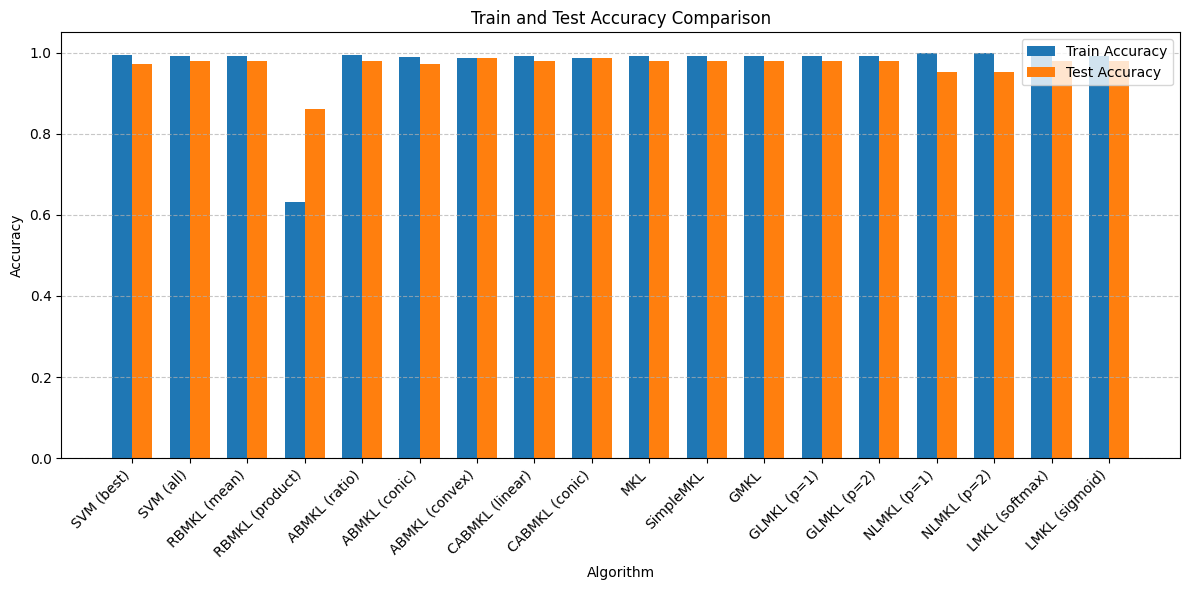

In [52]:
plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

train_accs = [r['Train Accuracy'] for r in results]
test_accs = [r['Test Accuracy'] for r in results]

plt.bar(x - width/2, train_accs, width, label='Train Accuracy')
plt.bar(x + width/2, test_accs, width, label='Test Accuracy')

plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Comparison')
plt.xticks(x, [r['Algorithm'] for r in results], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Visualize kernel weights


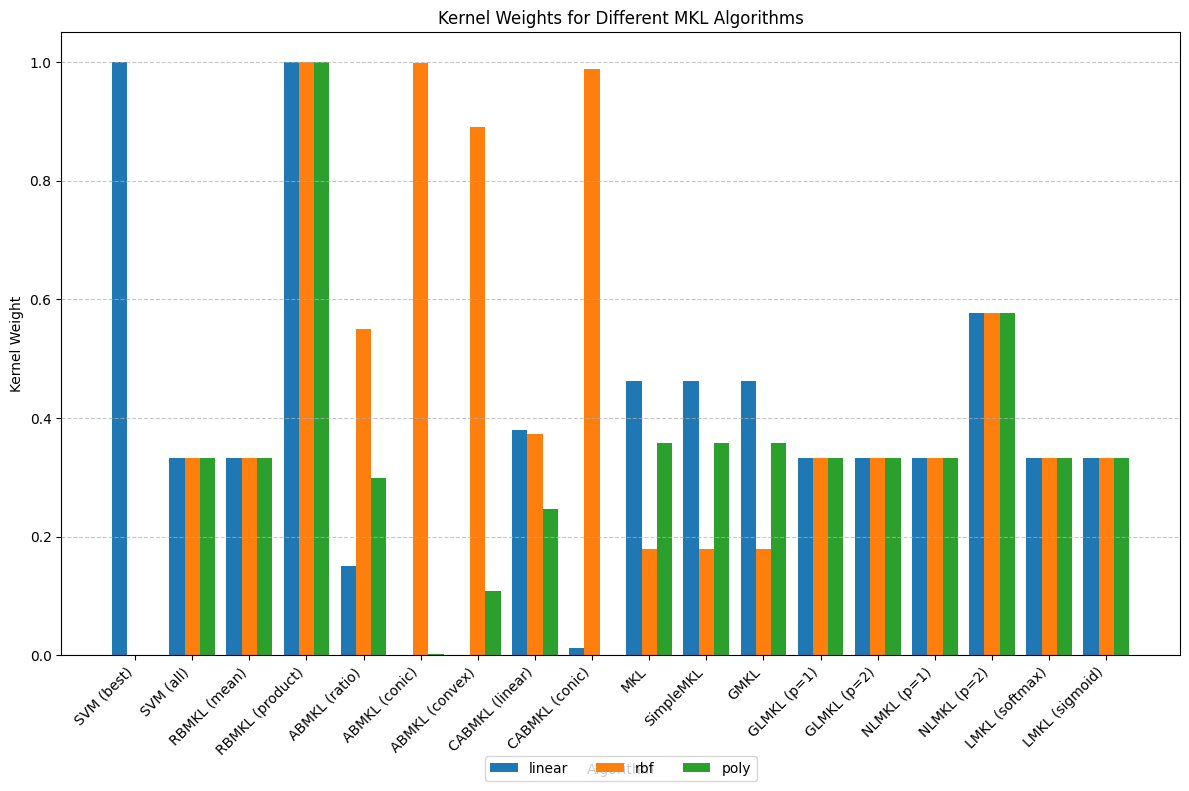

In [53]:
plt.figure(figsize=(12, 8))
bar_width = 0.8 / 3
kernel_types = ['linear', 'rbf', 'poly']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

valid_results = [r for r in results if r['Kernel Weights'] is not None]

for i, result in enumerate(valid_results):
    weights = result['Kernel Weights']
    if weights is not None and len(weights) == 3:
        x = np.arange(len(valid_results))
        for j in range(3):
            plt.bar(x[i] + j*bar_width - bar_width, weights[j], bar_width,
                    label=kernel_types[j] if i == 0 else "", color=colors[j])

plt.xlabel('Algorithm')
plt.ylabel('Kernel Weight')
plt.title('Kernel Weights for Different MKL Algorithms')
plt.xticks(np.arange(len(valid_results)), [r['Algorithm'] for r in valid_results], rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)